Цель: Проанализировать данные о заработной плате сотрудников из файла ds_salaries.csv и построить модели машинного обучения для прогнозирования заработной платы.  

Задачи:  

1. Первичный анализ данных:  
— Импортировать данные из файла ds_salaries.csv.  
— Очистить данные от дубликатов и пропущенных значений.   
— Исследовать типы данных, описательную статистику и корреляции между признаками.  
— Визуализировать данные с помощью Matplotlib и Seaborn.  



In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
from pathlib import Path

In [15]:
dataset_filename = './ds_salaries.csv'
df = pd.read_csv(dataset_filename)

In [16]:
# Датафрейм содержит 1171 полных дубликатов. Их нужно удалить
df.duplicated().value_counts()

False    2584
True     1171
Name: count, dtype: int64

In [17]:
df.drop_duplicates(inplace=True)

In [18]:
# Сгруппируем основную информацию о датасете и выгрузим в excel.
# import io
info_filename = f'./{Path(dataset_filename).stem}_info.xlsx'
buf = io.StringIO()
df.info(buf=buf)
s = buf.getvalue()
columns = s.splitlines()[3].split()
lines =   [line.split() for line in s.splitlines()[5:-2]]
lines = [[' '.join(row[1:-3]), row[-3], row[-2], row[-1]   ] for row in lines]
# lines
# columns[1:]
# df_info = pd.DataFrame(lines,columns=columns[1:])
# df_info['nu'] = df.nunique().values
# df.nunique().n
# df_info.join(df.nunique(), on='Column')
# df.nunique().to_frame(name='Columns').reset_index()
# pd.concat([pd.DataFrame(lines,columns=columns[1:]), df.nunique()], axis=1, ignore_index=True)# .set_index(['#']).reset_index()
df_info = pd.merge(
    pd.DataFrame(lines, columns=columns[1:])
    , df.nunique().to_frame(name='Nu'), 
    left_on='Column', 
    right_index=True)# .set_index(['#']).reset_index()
df_vc = pd.DataFrame([[col, sorted(df[col].value_counts().to_dict().items(), key=lambda x: x[0])] for col in df.columns if len(df[col].value_counts()) < 21], columns=['Column', 'vc'])
df_info = pd.merge(df_info, df_vc, how='left', on='Column')
df_info = pd.merge(df_info, df.describe().T, how='left', left_on='Column', right_index=True)
if not Path(info_filename).exists():
    df_info.to_excel(info_filename)
df_info

,Column,Non-Null,Count,Dtype,Nu,vc,count,mean,std,min,25%,50%,75%,max
0,work_year,2584,non-null,int64,4,"[(2020, 75), (2021, 228), (2022, 1125), (2023,...",2584.0,2022.301084,0.749179,2020.0,2022.0,2022.0,2023.0,2023.0
1,experience_level,2584,non-null,object,4,"[(EN, 270), (EX, 96), (MI, 664), (SE, 1554)]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,employment_type,2584,non-null,object,4,"[(CT, 10), (FL, 10), (FT, 2547), (PT, 17)]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,job_title,2584,non-null,object,93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,salary,2584,non-null,int64,815,NaN,2584.0,210365.296440,808037.535609,6000.0,90000.0,134630.0,182562.5,30400000.0
5,salary_currency,2584,non-null,object,20,"[(AUD, 9), (BRL, 6), (CAD, 25), (CHF, 4), (CLP...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,salary_in_usd,2584,non-null,int64,1035,NaN,2584.0,133409.280186,67136.837329,5132.0,84975.0,130000.0,175000.0,450000.0
7,employee_residence,2584,non-null,object,78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,remote_ratio,2584,non-null,int64,3,"[(0, 1186), (50, 187), (100, 1211)]",2584.0,50.483746,48.163707,0.0,0.0,50.0,100.0,100.0
9,company_location,2584,non-null,object,72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
# Датасет не содержим явных и неявных пропусков
# Выделим в датасете числовые и категориальные признаки
target_name = 'salary_in_usd'
num_features = ['salary']
cat_features = ['work_year', 'experience_level', 'employment_type', 'job_title', 'salary_currency', 'employee_residence', 'remote_ratio', 'company_location', 'company_size']

c:\Users\Alex\My Documents\gb\Python_2022\.python_b_hw\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


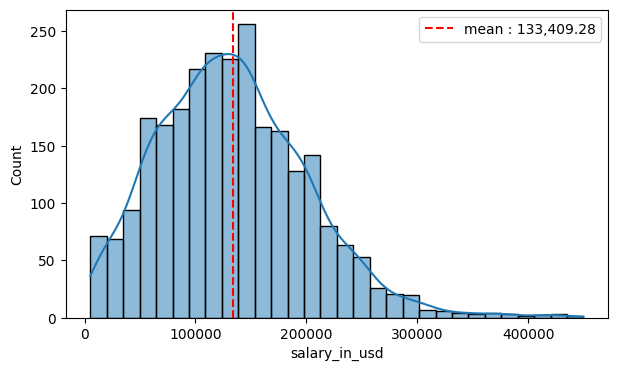

In [34]:
# Отобразим график распределения целевой переменной
target_feature_mean = df[target_name].mean()
plt.figure(figsize=(7,4))
g1 = sns.histplot(x=df[target_name], bins=30, kde=True);
g1.axvline(target_feature_mean, color='red', ls='--', label=f"mean : {target_feature_mean:,.2f}")
plt.legend();
# Наблюдаем распределение целевой переменной похожее на нормальное с правым "хвостом"
# Пока не понято являются ли большие значения выбросами

In [35]:
df.loc[df[target_name]>350_000]
# Высокие значения зпл наблюдаются у работников с высокой квалификацией. На данном этапе, предположим, что это не выбросы.

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
478,2023,EX,FT,Director of Data Science,353200,USD,353200,US,0,US,M
528,2023,SE,FT,AI Scientist,1500000,ILS,423834,IL,0,IL,L
649,2023,SE,FT,Data Architect,376080,USD,376080,US,100,US,M
1105,2023,SE,FT,Data Scientist,370000,USD,370000,US,0,US,M
1258,2022,SE,FT,Machine Learning Software Engineer,375000,USD,375000,US,100,US,M
1288,2023,SE,FT,Data Analyst,385000,USD,385000,US,0,US,M
1311,2023,SE,FT,Research Scientist,370000,USD,370000,US,0,US,M
2011,2022,MI,FT,Data Analyst,350000,GBP,430967,GB,0,GB,M
2359,2022,SE,FT,Data Science Tech Lead,375000,USD,375000,US,50,US,L
3463,2022,SE,FT,Data Analytics Lead,405000,USD,405000,US,100,US,L


<AxesSubplot: xlabel='work_year', ylabel='salary_in_usd'>

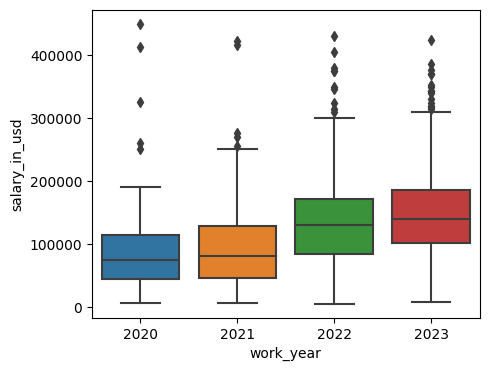

In [27]:
# Отобразим уровень зарплаты в USD в зависимости от года выплаты
plt.figure(figsize=(5, 4))
sns.boxplot(y=df[target_name], x=df['work_year']);

2. Построение модели линейной регрессии:\
— Разделить данные на обучающую и тестовую выборки.\
— Построить модель линейной регрессии для прогнозирования заработной платы.\
— Оценить качество модели с помощью метрик MAE, MSE и R-квадрат.\
— Проанализировать значимость признаков и мультиколлинеарность.

In [ ]:
3. Построение модели дерева решений:
— Построить модель дерева решений для прогнозирования заработной платы.
— Оценить качество модели с помощью метрик RMSE и R-квадрат.
— Подберите гиперпараметры для модели дерево решений
— Визуализировать дерево решений.



In [ ]:
4. Построение ансамблевой модели:
— Построить ансамблевую модель, используя Random Forest и Boosting.
— Сравнить качество ансамблевой модели с отдельными моделями.
— Оценить важность признаков в ансамблевой модели.



In [ ]:
5. Понижение размерности:
— Применить Principal Component Analysis (PCA) для снижения размерности данных.
— Построить модель линейной регрессии с использованием данных, полученных после PCA.
— Сравнить качество модели с использованием исходных данных.



In [ ]:
7. Кластеризация:
— Применить метод K-Means для кластеризации данных по заработной плате.
— Определить оптимальное количество кластеров.
— Проанализировать характеристики полученных кластеров.
— Визуализировать результаты кластеризации и проанализировать характеристики в каждом кластере.
— Проанализируйте полученные данные и сделайте выводы о том, какой алгоритм кластеризации сможет выделить кластеры лучше, чем K-Means.